In [1]:
import numpy as np
from pyomo.environ import *
from pyomo.dae import *
import pandas as pd

from mpclab_common.track import get_track

In [2]:
def compute_raceline(track_name, vehicle_config, vehicle_constraints):

    #SYSTEM STATES:  vx=x[0],  vy=x[1], wz=x[2] ,e_psi=x[3], t=x[4], e_y=x[5]
    #SYSTEM INPUTS:  ax[m/s^2]=u0, steering(rad)=u1
    #INDEPENDENT VARIABLE IS s (space)

    track = get_track(track_name)

    lf = vehicle_config.wheel_dist_front
    lr = vehicle_config.wheel_dist_rear

    mass = vehicle_config.mass
    Iz = vehicle_config.yaw_inertia

    tire_model = vehicle_config.tire_model

    mu = vehicle_config.wheel_friction
    Br = vehicle_config.pacejka_b_rear
    Bf = vehicle_config.pacejka_b_front
    Cr = vehicle_config.pacejka_c_rear
    Cf = vehicle_config.pacejka_c_front
    Dr = vehicle_config.pacejka_d_rear
    Df = vehicle_config.pacejka_d_front

    xu_ub = vehicle_constraints['xu_ub']
    xu_lb = vehicle_constraints['xu_lb']
    du_ub = vehicle_constraints['du_ub']
    du_lb = vehicle_constraints['du_lb']

    v_long_max = xu_ub.v.v_long
    v_long_min = xu_lb.v.v_long
    v_tran_max = xu_ub.v.v_tran
    v_tran_min = xu_lb.v.v_tran
    psidot_max = xu_ub.w.w_psi
    psidot_min = xu_lb.w.w_psi
    e_psi_max = xu_ub.p.e_psi
    e_psi_min = xu_lb.p.e_psi
    e_y_max = xu_ub.p.x_tran
    e_y_min = xu_lb.p.x_tran

    a_max = xu_ub.u.u_a
    a_min = xu_lb.u.u_a
    steer_max = xu_ub.u.u_steer
    steer_min = xu_lb.u.u_steer

    a_rate_max = du_ub.u_a
    a_rate_min = du_lb.u_a
    steer_rate_max = du_ub.u_steer
    steer_rate_min = du_lb.u_steer

    print('=================== Raceline computation ===================')
    print('Track name: %s' % track_name)
    print('     - length: %g m' % track.track_length)
    print('     - width: %g m' % (track.half_width*2))
    print('Vehicle configuration:')
    print('     - center of mass to front axle: %g m' % lf)
    print('     - center of mass to rear axle: %g m' % lr)
    print('     - mass: %g kg' % mass)
    print('     - yaw inertia: %g kg m^2' % Iz)
    print('     - tire model: %s' % tire_model)
    print('     - tire friction coefficient: %g' % mu)
    print('     - Front tires:')
    print('         - B: %g' % Bf)
    print('         - C: %g' % Cf)
    print('         - D: %g' % Df)
    print('     - Rear tires:')
    print('         - B: %g' % Br)
    print('         - C: %g' % Cr)
    print('         - D: %g' % Dr)
    print('Vehicle input constraints:')
    print('     - max acceleration: %g m/s^2' % a_max)
    print('     - min acceleration: %g m/s^2' % a_min)
    print('     - max steering angle: %g rad' % steer_max)
    print('     - min steering angle: %g rad' % steer_min)
    print('Vehicle state constraints:')
    print('     - max longitudinal velocity: %g m/s' % v_long_max)
    print('     - min longitudinal velocity: %g m/s' % v_long_min)
    print('     - max lateral velocity: %g m/s' % v_tran_max)
    print('     - min lateral velocity: %g m/s' % v_tran_min)
    print('     - max yaw rate: %g rad/s' % psidot_max)
    print('     - min yaw rate: %g rad/s' % psidot_min)
    print('============================================================')

    model = m = ConcreteModel()
    m.sf = Param(initialize=track.track_length)
    m.s = ContinuousSet(bounds=(0, m.sf))

    m.u0 = Var(m.s, bounds=(a_min, a_max), initialize=0)
    m.u1 = Var(m.s, bounds=(steer_min, steer_max), initialize=0)
    m.alpha_f = Var(m.s, initialize=0)
    m.alpha_r = Var(m.s, initialize=0)
    m.Fyf = Var(m.s,bounds=(-mass*9.8, mass*9.8), initialize=0)
    m.Fyr = Var(m.s,bounds=(-mass*9.8, mass*9.8), initialize=0)
    m.x0 = Var(m.s, bounds=(v_long_min, v_long_max), initialize=0.01)
    m.x1 = Var(m.s, bounds=(v_tran_min, v_tran_max), initialize=0)
    m.x2 = Var(m.s, bounds=(psidot_min, psidot_max), initialize=0)
    m.x3 = Var(m.s, bounds=(e_psi_min, e_psi_max))
    m.x4 = Var(m.s, bounds=(0, 20000), initialize=0)
    m.x5 = Var(m.s, bounds=(e_y_min, e_y_max), initialize=0)

    m.dx0ds = DerivativeVar(m.x0, wrt=m.s)
    m.dx1ds = DerivativeVar(m.x1, wrt=m.s)
    m.dx2ds = DerivativeVar(m.x2, wrt=m.s)
    m.dx3ds = DerivativeVar(m.x3, wrt=m.s)
    m.dx4ds = DerivativeVar(m.x4, wrt=m.s)
    m.dx5ds = DerivativeVar(m.x5, wrt=m.s)
    m.du0ds = DerivativeVar(m.u0, wrt=m.s)
    m.du1ds = DerivativeVar(m.u1, wrt=m.s)

    # to avoid divide by 0
    eps=0.000001

    #Objective function
    m.obj = Objective(expr=m.x4[m.sf] + 0.01*sum(m.du0ds[i]**2 for i in m.s) + 0.01*sum(m.du1ds[i]**2 for i in m.s), sense=minimize)
    # ways to tune the cost:
        # penalize u1
        # penalize u2
        # penalize u1 and u2
        # vary the penalizations on u1 and u2
        # penalize the input rate
    # to do: write this optimization problem as a function that gets called
    # different arguments will choose a different objective tuning
    # function output should be the DF, then we can store them all

    #sideslip and lateral force
    def _alphafc(m, s):
        return m.alpha_f[s] == m.u1[s] - atan((m.x1[s] + lf * m.x2[s])/ (m.x0[s]))
    m.c4 = Constraint(m.s, rule=_alphafc)
    def _alpharc(m, s):
        return m.alpha_r[s] == -atan((m.x1[s] - lr * m.x2[s])/ (m.x0[s]))
    m.c3 = Constraint(m.s, rule=_alpharc)

    if tire_model == 'linear':
        def _Fyfc(m, s):
            return m.Fyf[s] ==  Df * Cf * Bf * m.alpha_f[s]
        m.c2 = Constraint(m.s, rule=_Fyfc)
        def _Fyrc(m, s):
            return m.Fyr[s] ==  Dr * Cr * Br * m.alpha_r[s]
        m.c1 = Constraint(m.s, rule=_Fyrc)
    elif tire_model == 'pacejka':
        def _Fyfc(m, s):
            return m.Fyf[s] ==  Df * sin(Cf * atan(Bf * m.alpha_f[s]))
        m.c2 = Constraint(m.s, rule=_Fyfc)
        def _Fyrc(m, s):
            return m.Fyr[s] ==  Dr * sin(Cr * atan(Br * m.alpha_r[s]))
        m.c1 = Constraint(m.s, rule=_Fyrc)

    #Differential model definition
    def _x0dot(m, s):
        cur = track.get_curvature(s)
        # print(cur)
        return m.dx0ds[s] == (m.u0[s] - 1 / mass *  m.Fyf[s] * sin(m.u1[s]) + m.x2[s]*m.x1[s])*((1 - cur * m.x5[s]) /(eps+m.x0[s] * cos(m.x3[s]) - m.x1[s] * sin(m.x3[s])))
    m.x0dot = Constraint(m.s, rule=_x0dot)

    def _x1dot(m, s):
        cur = track.get_curvature(s)
        return m.dx1ds[s] == (1 / mass * (m.Fyf[s] * cos(m.u1[s]) + m.Fyr[s]) - m.x2[s] * m.x0[s])*((1 - cur * m.x5[s]) /(eps+m.x0[s] * cos(m.x3[s]) - m.x1[s] * sin(m.x3[s])))
    m.x1dot = Constraint(m.s, rule=_x1dot)

    def _x2dot(m, s):
        cur = track.get_curvature(s)
        return m.dx2ds[s] == (1 / Iz *(lf*m.Fyf[s] * cos(m.u1[s]) - lr * m.Fyr[s]) )*((1 - cur * m.x5[s]) /(eps+m.x0[s] * cos(m.x3[s]) - m.x1[s] * sin(m.x3[s])))
    m.x2dot = Constraint(m.s, rule=_x2dot)

    def _x3dot(m, s):
        cur = track.get_curvature(s)
        return m.dx3ds[s] == ( m.x2[s]*(1 - cur * m.x5[s])/(eps+m.x0[s] * cos(m.x3[s]) - m.x1[s] * sin(m.x3[s])) - cur)
    m.x3dot = Constraint(m.s, rule=_x3dot)

    def _x4dot(m, s):
        cur = track.get_curvature(s)
        return m.dx4ds[s] == ((1 - cur * m.x5[s]) /(eps+m.x0[s] * cos(m.x3[s]) - m.x1[s] * sin(m.x3[s])))
    m.x4dot = Constraint(m.s, rule=_x4dot)

    def _x5dot(m, s):
        cur = track.get_curvature(s)
        return m.dx5ds[s] == (m.x0[s] * sin(m.x3[s]) + m.x1[s] * cos(m.x3[s]))*((1 - cur * m.x5[s]) /(eps+m.x0[s] * cos(m.x3[s]) - m.x1[s] * sin(m.x3[s])))
    m.x5dot = Constraint(m.s, rule=_x5dot)

    # rate constraints on acceleration
    # def _u0dotmax(m, s):
    #     cur = track.get_curvature(s)
    #     return m.du0ds[s] <= a_rate_max*((1 - cur * m.x5[s]) /(eps+m.x0[s] * cos(m.x3[s]) - m.x1[s] * sin(m.x3[s])))
    # m.i0dotub = Constraint(m.s, rule=_u0dotmax)
    # def _u0dotmin(m, s):
    #     cur = track.get_curvature(s)
    #     return m.du0ds[s] >= a_rate_min*((1 - cur * m.x5[s]) /(eps+m.x0[s] * cos(m.x3[s]) - m.x1[s] * sin(m.x3[s])))
    # m.i0dotlb = Constraint(m.s, rule=_u0dotmin)

    # rate constraints on steering
#     def _u1dotmax(m, s):
#         cur = track.get_curvature(s)
#         return m.du1ds[s] <= steer_rate_max*((1 - cur * m.x5[s]) /(eps+m.x0[s] * cos(m.x3[s]) - m.x1[s] * sin(m.x3[s])))
#     m.i1dotub = Constraint(m.s, rule=_u1dotmax)
#     def _u1dotmin(m, s):
#         cur = track.get_curvature(s)
#         return m.du1ds[s] >= steer_rate_min*((1 - cur * m.x5[s]) /(eps+m.x0[s] * cos(m.x3[s]) - m.x1[s] * sin(m.x3[s])))
#     m.i1dotlb = Constraint(m.s, rule=_u1dotmin)

    # inital and terminal conditions
    def _init(m):
        # yield m.x5[0] == m.x5[track.track_length]
        yield m.x0[0] == m.x0[track.track_length]
        yield m.x1[0] == m.x1[track.track_length]
        yield m.x2[0] == m.x2[track.track_length]
        yield m.x3[0] == m.x3[track.track_length]
        yield m.x4[0] == 0
        yield m.x5[0] == m.x5[track.track_length]
    m.init_conditions = ConstraintList(rule=_init)

    # Discretize model using radau or finite difference collocation
    TransformationFactory('dae.collocation').apply_to(m, nfe=200, ncp=10, scheme='LAGRANGE-LEGENDRE') #STANDARD METHOD

    # Solve algebraic model
    solver = SolverFactory('ipopt')
    # Solver options
    solver.options['max_iter'] = 8000
    results = solver.solve(m,tee=True)

    # Evaluate solution at discretization points
    s_vec = list(sorted(m.s.data()))

    raceline = {'t': np.zeros(len(s_vec)),
                'x' : np.zeros(len(s_vec)),
                'y' : np.zeros(len(s_vec)),
                'psi' : np.zeros(len(s_vec)),
                's' : np.zeros(len(s_vec)),
                'e_y' : np.zeros(len(s_vec)),
                'e_psi' : np.zeros(len(s_vec)),
                'v_long' : np.zeros(len(s_vec)),
                'v_tran' : np.zeros(len(s_vec)),
                'psidot' : np.zeros(len(s_vec)),
                'u_a': np.zeros(len(s_vec)),
                'u_s': np.zeros(len(s_vec))}

    for j in range(len(s_vec)):
        s = s_vec[j]

        local_pos = (s, value(m.x5[s]), 0)
        (x, y, psi) = track.local_to_global(local_pos)

        raceline['t'][j] = value(m.x4[s])
        raceline['v_long'][j] = value(m.x0[s])
        raceline['v_tran'][j] = value(m.x1[s])
        raceline['psidot'][j] = value(m.x2[s])
        raceline['s'][j] = s
        raceline['e_y'][j] = value(m.x5[s])
        raceline['e_psi'][j] = value(m.x3[s])
        raceline['x'][j] = x
        raceline['y'][j] = y
        raceline['psi'][j] = psi
        raceline['u_a'][j] = value(m.u0[s])
        raceline['u_s'][j] = value(m.u1[s])

    DF = pd.DataFrame()

    return raceline, DF

def getValues(DF, s):
    m1x4 = np.interp(s, DF.index, DF['x4'].values)
    m1x5 = np.interp(s, DF.index, DF['x5'].values)

    return m1x4, m1x5

def plot_racelines(track_name, raceline):
    import matplotlib.pyplot as plt
    import os

    track = get_track(track_name)

    fig_xy = plt.figure(figsize=(20, 20))
    ax = fig_xy.gca()
    track.plot_map(ax)

    fig_ts = plt.figure(figsize=(50, 30))
    ax_vx = fig_ts.add_subplot(6, 1, 1)
    ax_vx.set_ylabel('vel long')
    ax_vy = fig_ts.add_subplot(6, 1, 2)
    ax_vy.set_ylabel('vel lat')
    ax_pd = fig_ts.add_subplot(6, 1, 3)
    ax_pd.set_ylabel('yaw rate')
    ax_ey = fig_ts.add_subplot(6, 1, 4)
    ax_ey.set_ylabel('e_y')
    ax_a = fig_ts.add_subplot(6, 1, 5)
    ax_a.set_ylabel('accel cmd')
    ax_s = fig_ts.add_subplot(6, 1, 6)
    ax_s.set_ylabel('steer cmd')
    ax_s.set_xlabel('s')

    vs = np.cos(raceline['v_long']) - np.sin(raceline['v_tran'])
    speed = np.sqrt(np.power(raceline['v_long'],2)+np.power(raceline['v_tran'],2))
    sc = ax.scatter(raceline['x'], raceline['y'], c=speed)
    ax.plot(raceline['x'], raceline['y'], 'b')

    ax_vx.plot(raceline['s'], raceline['v_long'], 'b')
    ax_vy.plot(raceline['s'], raceline['v_tran'], 'b')
    ax_pd.plot(raceline['s'], raceline['psidot'], 'b')
    ax_ey.plot(raceline['s'], raceline['e_y'], 'b')
    ax_a.plot(raceline['s'], raceline['u_a'], 'b')
    ax_s.plot(raceline['s'], raceline['u_s'], 'b')

    laptime = raceline['t'][-1]
    print(f'Lap time: {laptime}')

    ax.set_aspect('equal')
    plt.colorbar(mappable=sc, ax=ax)
    ax.set_title(f'time: {laptime:.2f} s')

    plt.draw()

=================== Raceline computation ===================
Track name: L_track_barc
     - length: 17.4614 m
     - width: 1.1 m
Vehicle configuration:
     - center of mass to front axle: 0.13 m
     - center of mass to rear axle: 0.13 m
     - mass: 2.158 kg
     - yaw inertia: 0.026188 kg m^2
     - tire model: pacejka
     - tire friction coefficient: 0.9
     - Front tires:
         - B: 5
         - C: 2.28
         - D: 9.52649
     - Rear tires:
         - B: 5
         - C: 2.28
         - D: 9.52649
Vehicle input constraints:
     - max acceleration: 1 m/s^2
     - min acceleration: -2 m/s^2
     - max steering angle: 0.43 rad
     - min steering angle: -0.43 rad
Vehicle state constraints:
     - max longitudinal velocity: 1 m/s
     - min longitudinal velocity: 0 m/s
     - max lateral velocity: 10 m/s
     - min lateral velocity: -10 m/s
     - max yaw rate: 1.5708 rad/s
     - min yaw rate: -1.5708 rad/s
Ipopt 3.14.0: max_iter=8000
ERROR: Output stream closed before all 

NameError: name 'r' is not defined

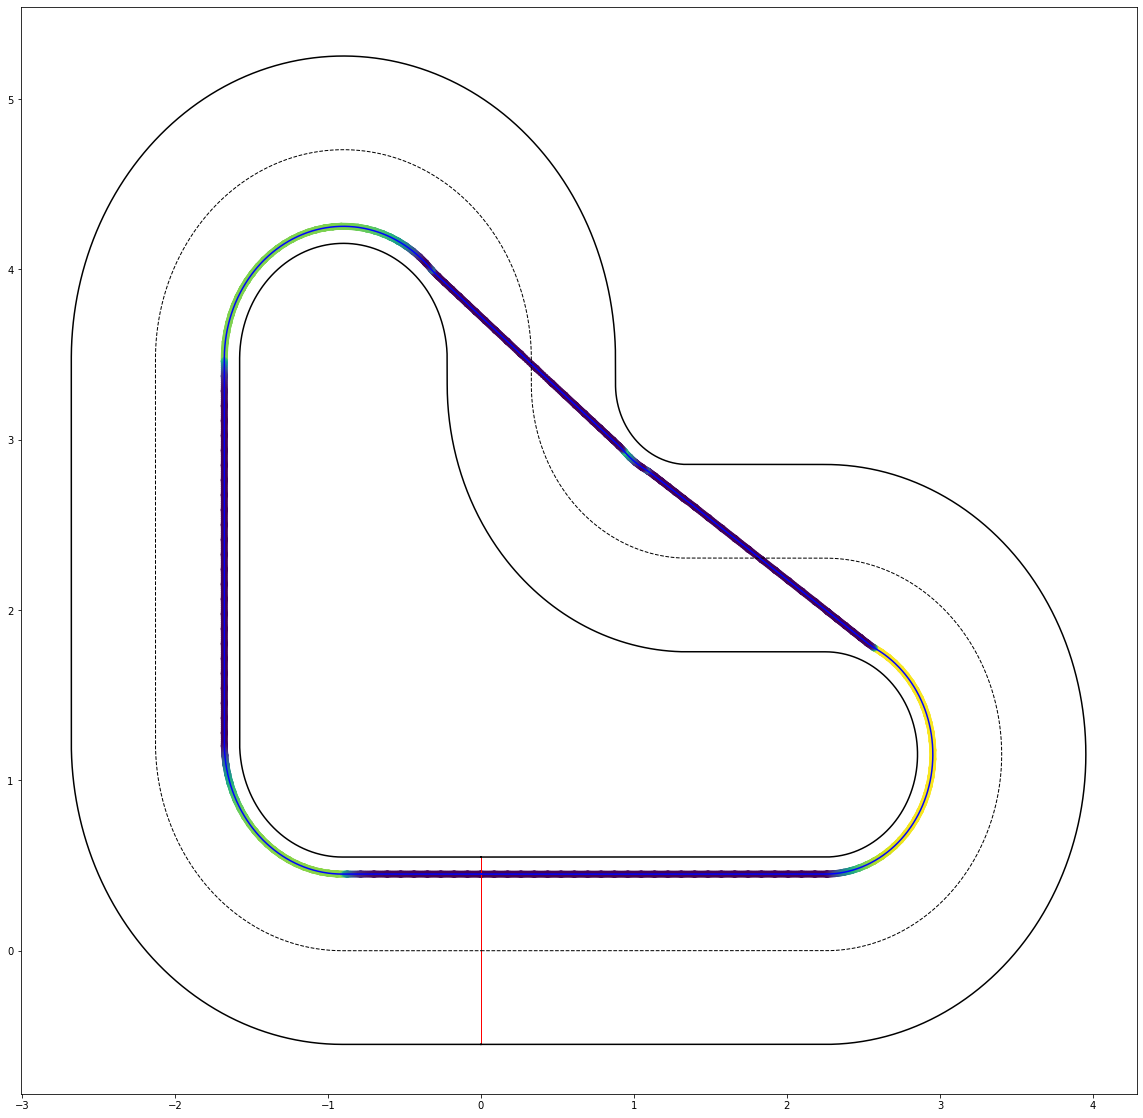

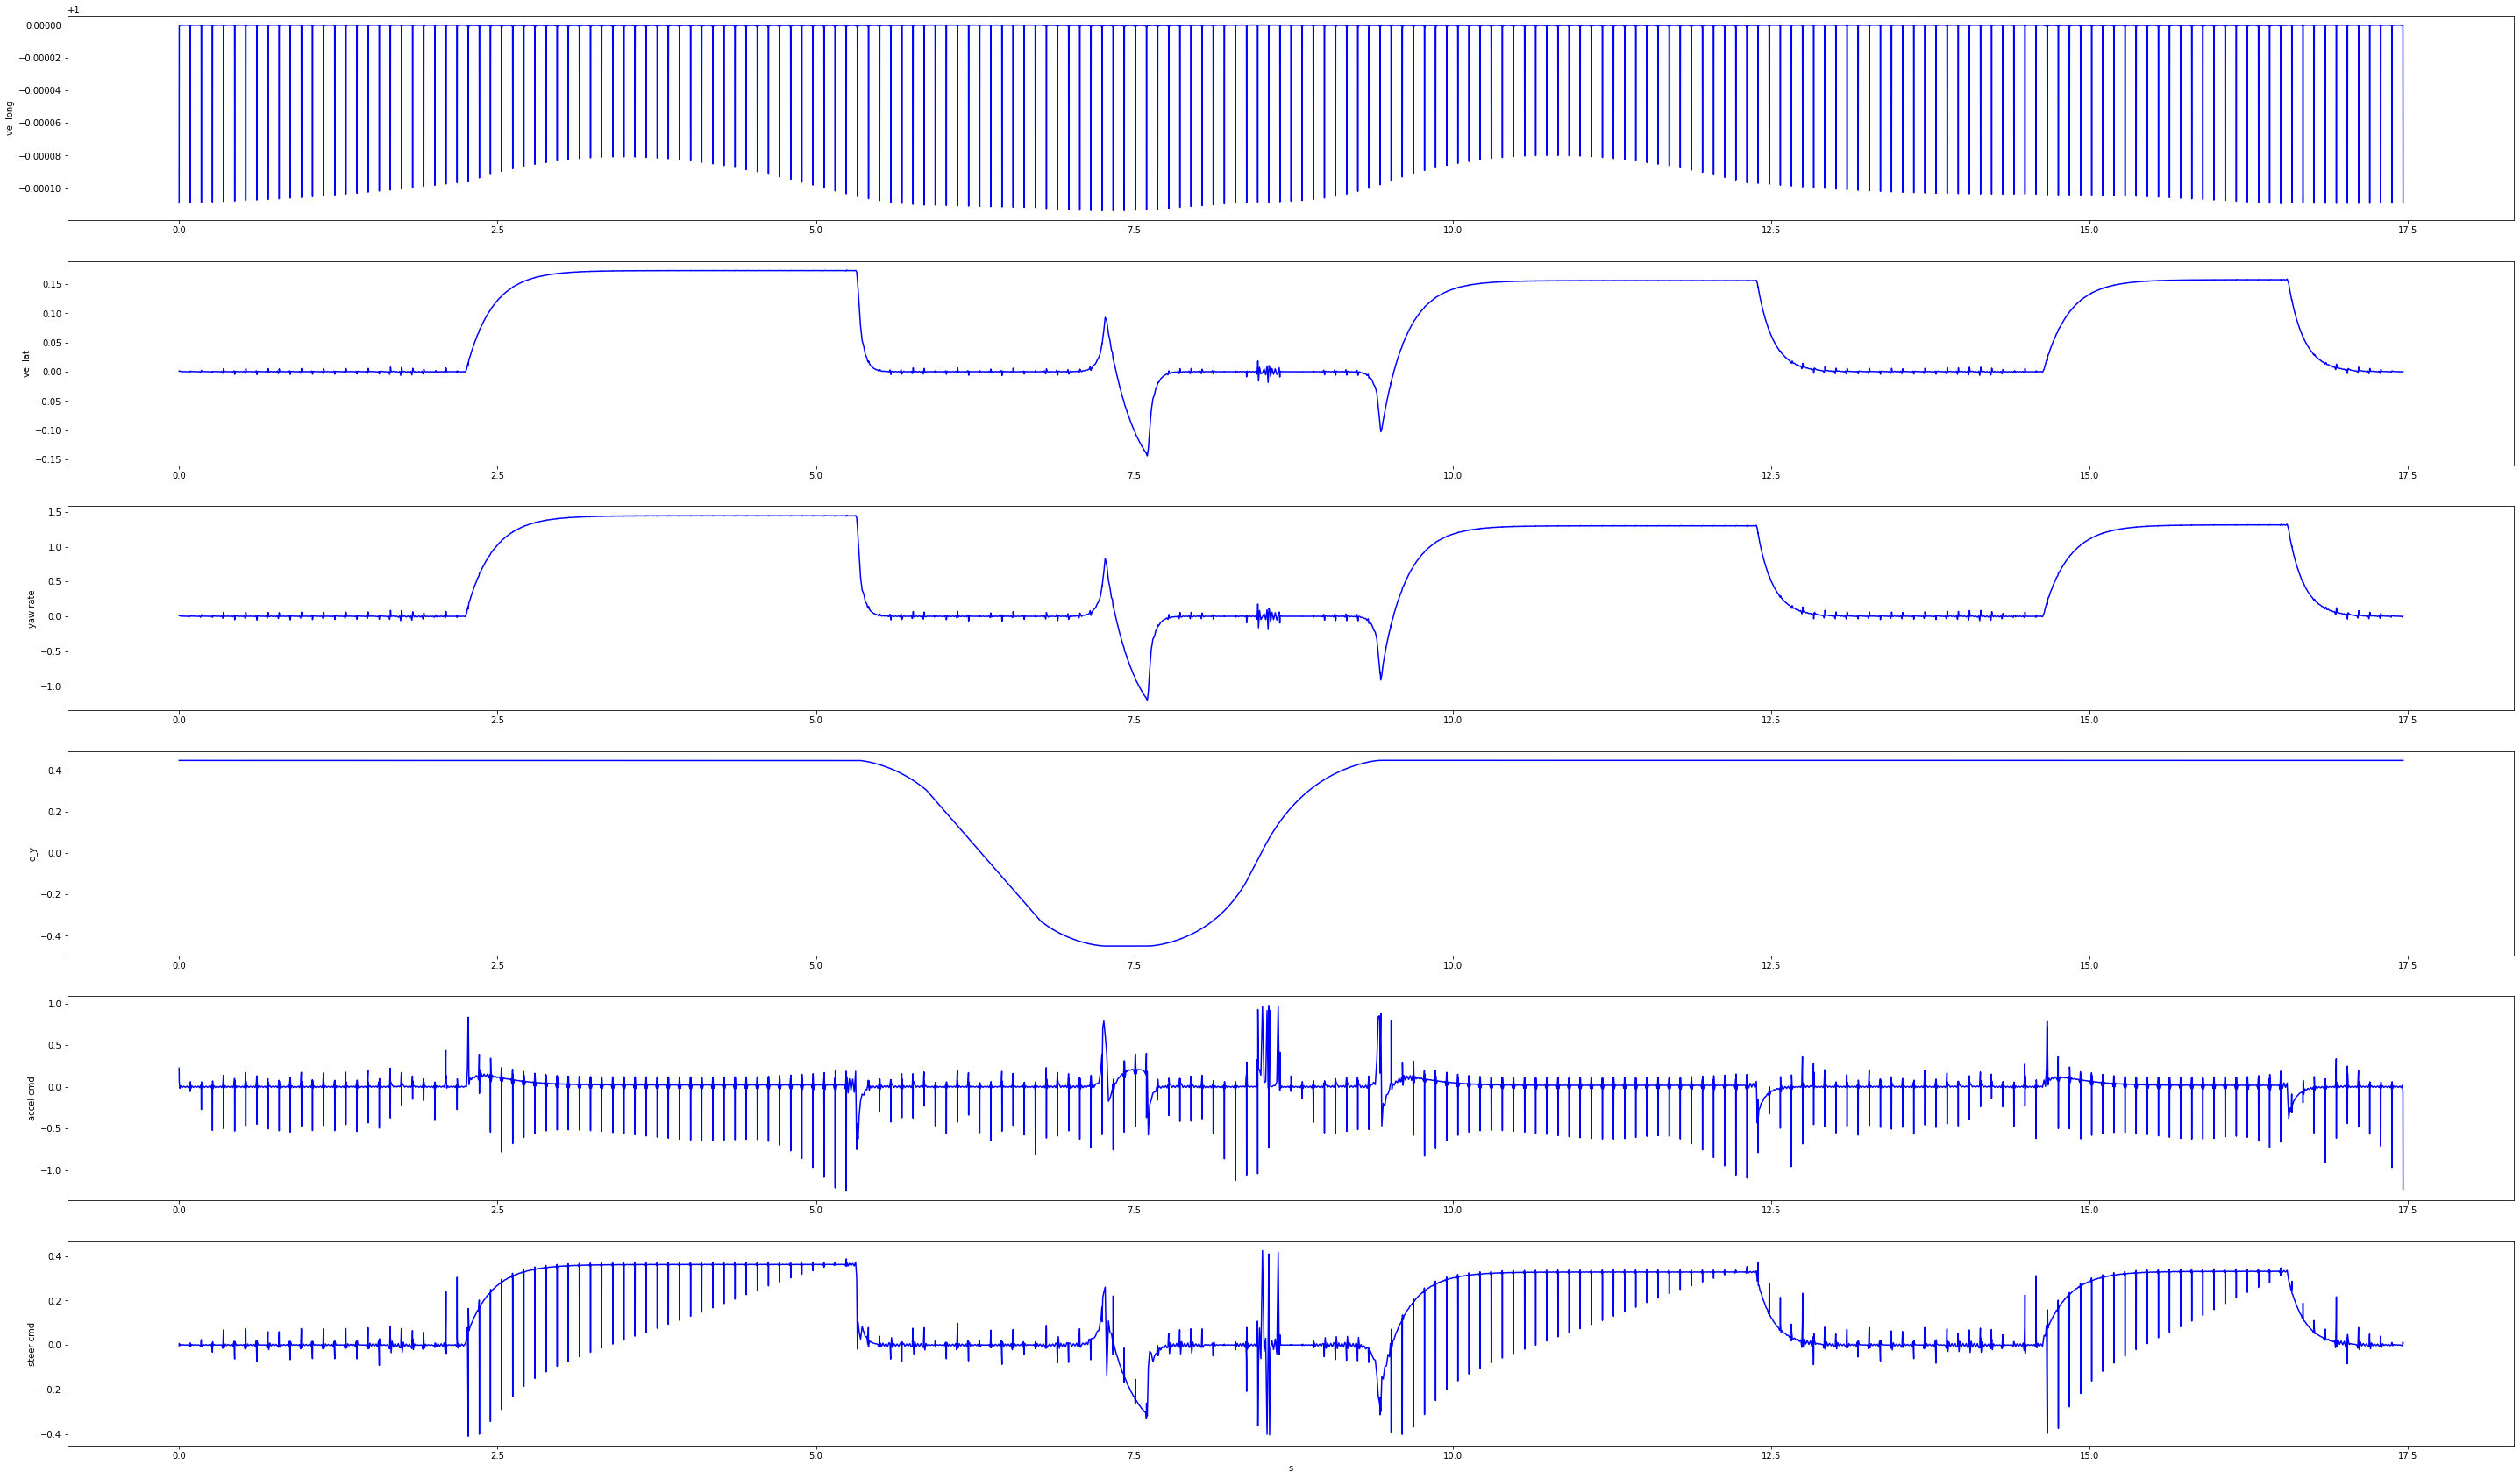

In [3]:
import os
from mpclab_common.models.model_types import DynamicBicycleConfig
from mpclab_common.pytypes import BodyAngularVelocity, BodyLinearVelocity, ParametricPose, VehicleState, VehicleActuation

track_name = 'L_track_barc'
track_obj = get_track(track_name)
H = track_obj.half_width

vehicle_config = DynamicBicycleConfig(wheel_dist_front=0.13,
                                    wheel_dist_rear=0.13,
                                    mass=2.158,
                                    yaw_inertia=0.026188,
                                    drag_coefficient=0.0,
                                    tire_model='pacejka',
                                    wheel_friction=0.9,
                                    pacejka_b_front=5.0,
                                    pacejka_b_rear=5.0,
                                    pacejka_c_front=2.28,
                                    pacejka_c_rear=2.28,
                                    simple_slip=False)

track_tightening = 0.1

state_input_ub = VehicleState(p=ParametricPose(x_tran=H-track_tightening, e_psi=0.3*np.pi),
                              v=BodyLinearVelocity(v_long=1.0, v_tran=10),
                              w=BodyAngularVelocity(w_psi=np.pi/2),
                              u=VehicleActuation(u_a=1.0, u_steer=0.43))
state_input_lb = VehicleState(p=ParametricPose(x_tran=-(H-track_tightening), e_psi=-0.3*np.pi),
                              v=BodyLinearVelocity(v_long=0, v_tran=-10),
                              w=BodyAngularVelocity(w_psi=-np.pi/2),
                              u=VehicleActuation(u_a=-2.0, u_steer=-0.43))
input_rate_ub = VehicleActuation(u_a=40, u_steer=4.5)
input_rate_lb = VehicleActuation(u_a=-40, u_steer=-4.5)
vehicle_constraints = {'xu_ub': state_input_ub, 'xu_lb': state_input_lb, 'du_ub': input_rate_ub, 'du_lb': input_rate_lb}

# Compute raceline
raceline, raceline_data = compute_raceline(track_name, vehicle_config, vehicle_constraints)

# Plot raceline
plot_racelines(track_name, raceline)

# Save raceline
filename = 'raceline.npz'
save_path = os.path.join(save_dir, filename)
np.savez(filename, **raceline)